# Explanation
In the first attempt, we will try to build a prototype model, with the simplest approach, and see how can we extend from there.

In [1]:
# Since we are working on google colab for the GPU
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns


from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# EDA
We are suppose to look at our dataset in an attempt to understand how each feature behaves.  


---
2024.04.21.  
My friend provided a very good things to check in this phase: to look at if a column is null, how would that relates to the label.  
to look at cross entropy, see how much information do we get after knowing certain feature = certain value.  
Encode catagorical features based on the cross entropy.  


First we will read the data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/data.csv', index_col=0)
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1464479,201104109,W-626311,FED,DOI-WFMI,BIA,USMTFBA,Fort Belknap Agency,MTFBA,Fort Belknap Agency,42,NaN,GB2S,WEST DODSON,NaN,NaN,NaN,NaN,NaN,2011,2455795.5,234,1645.0,Miscellaneous,2455795.5,234.0,1800.0,0.1,A,48.40330,-108.28960,8.0,PRIVATE,MT,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\xf8:p\xce\x88\x12[\...
1,1591094,201608816,SFO-NE-2012-16029,NONFED,ST-NASF,ST/C&L,USNENES,Nebraska Department of Forestry,NENFS,Nebraska Forest Service,NaN,16029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,2456066.5,140,1547.0,Miscellaneous,2456066.5,140.0,1630.0,1.5,B,40.66846,-99.08913,14.0,MISSING/NOT SPECIFIED,NE,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\xe8\xc5PN\xb4\xc5X\...
2,944726,1072277,SWRA_VA_11300,NONFED,ST-VAVAS,ST/C&L,USVAVAS,Virginia Department of Forestry,VAVAS3,Farmville District,NaN,9801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,2452278.5,4,NaN,Miscellaneous,NaN,NaN,NaN,2.0,B,39.00000,-78.26920,14.0,MISSING/NOT SPECIFIED,VA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00P\x05\xa3\x92:\x91S\...
3,896277,1022153,SWRA_LA_24392,NONFED,ST-LALAS,ST/C&L,USLALAS,Louisiana Office of Forestry,LALAS1,LAS District 1,NaN,LA1-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002,2452410.5,136,NaN,Arson,NaN,NaN,NaN,5.0,B,30.99330,-89.86390,14.0,MISSING/NOT SPECIFIED,LA,NaN,NaN,NaN,b'\x00\x01\xad\x10\x00\x00\xe8\xc09#JwV\xc0\xf...
4,1269039,1673620,SFO-KY-20320089011,NONFED,ST-NASF,ST/C&L,USKYKYS,Kentucky Division of Forestry,KYKYS,Kentucky Division of Forestry,NaN,20320089011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,2454574.5,109,2045.0,Debris Burning,2454574.5,109.0,2045.0,3.0,B,37.26921,-84.34258,14.0,MISSING/NOT SPECIFIED,KY,Rockcastle,203.0,Rockcastle,b'\x00\x01\xad\x10\x00\x00\xdc\x10\xaa\xd4\xec...


We know that our target column is STAT_CAUSE_DESCR, so let's look at the distribution of the labels.

---

We can see that the labels are not very balanced, so we might need to think of a way to balance the data later.  

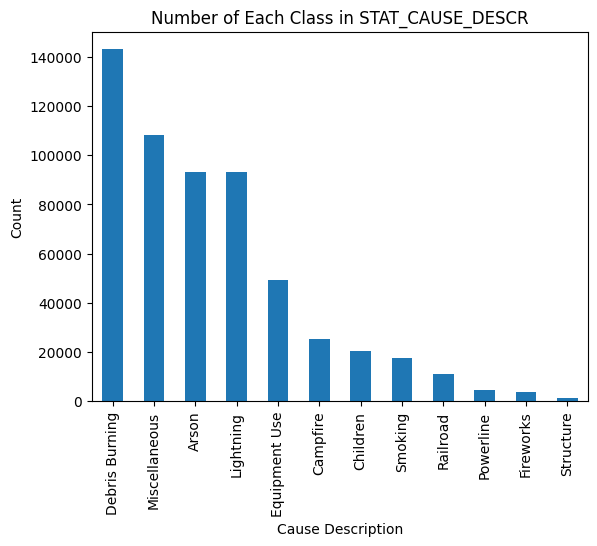

In [14]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar')

# Add labels and title
plt.title('Number of Each Class in STAT_CAUSE_DESCR')
plt.xlabel('Cause Description')
plt.ylabel('Count')

# Show the plot
plt.show()

Let's look at how many null are there in each columns


---
There are 571425 rows, and we can see that there are some columns with null values. Also we see that COUNTY, FIPS_CODE, and FIPS_NAME have the same number of null values, that might indicate that the null values are correlated.  
Also CONT_DOY have 367 unique number, that is also kind of wired.


In [5]:
column_stats = []
for column_name in df.columns:
    column = df[column_name]
    num_null = column.isnull().sum()
    total_values = len(column)
    null_percent = (num_null / total_values) * 100
    num_of_unique_values = len(column.unique())
    column_stats.append((column_name, num_null, null_percent,num_of_unique_values))

column_stats_df = pd.DataFrame(column_stats, columns=['ColumnName', 'NullNumber', 'NullPercentage', "UniqueValueNumber"])
column_stats_df

,ColumnName,NullNumber,NullPercentage,UniqueValueNumber
0,OBJECTID,0,0.000000,571425
1,FOD_ID,0,0.000000,571425
2,FPA_ID,0,0.000000,571425
3,SOURCE_SYSTEM_TYPE,0,0.000000,3
4,SOURCE_SYSTEM,0,0.000000,32
5,NWCG_REPORTING_AGENCY,0,0.000000,10
6,NWCG_REPORTING_UNIT_ID,0,0.000000,1345
7,NWCG_REPORTING_UNIT_NAME,0,0.000000,1341
8,SOURCE_REPORTING_UNIT,0,0.000000,4124
9,SOURCE_REPORTING_UNIT_NAME,0,0.000000,3611


Let's delve deeper into the null values

<Axes: >

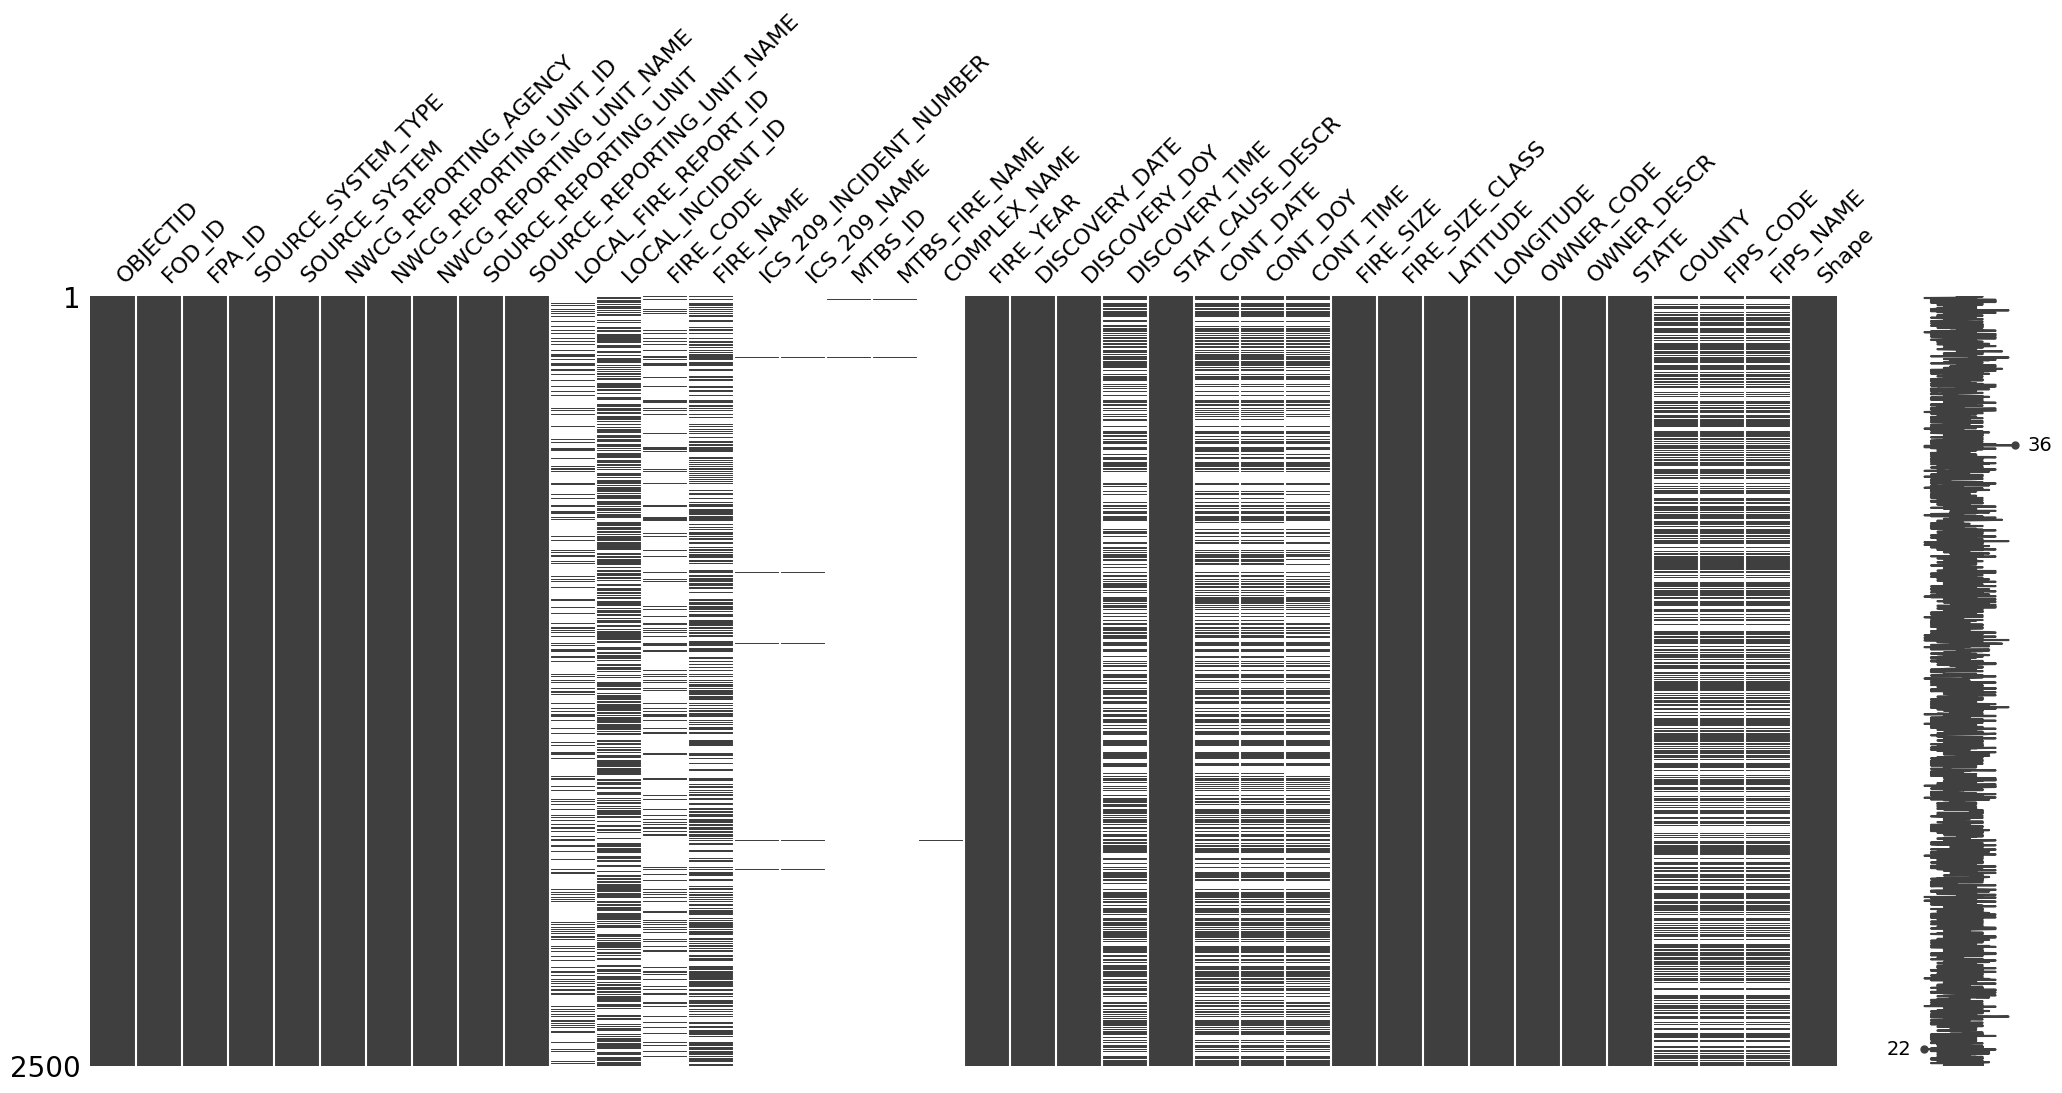

In [6]:
import missingno as msno
%matplotlib inline
msno.matrix(df.sample(2500))

Let's look at nullity correlation: how strongly the presence or absence of one variable affects the presence of another:

<Axes: >

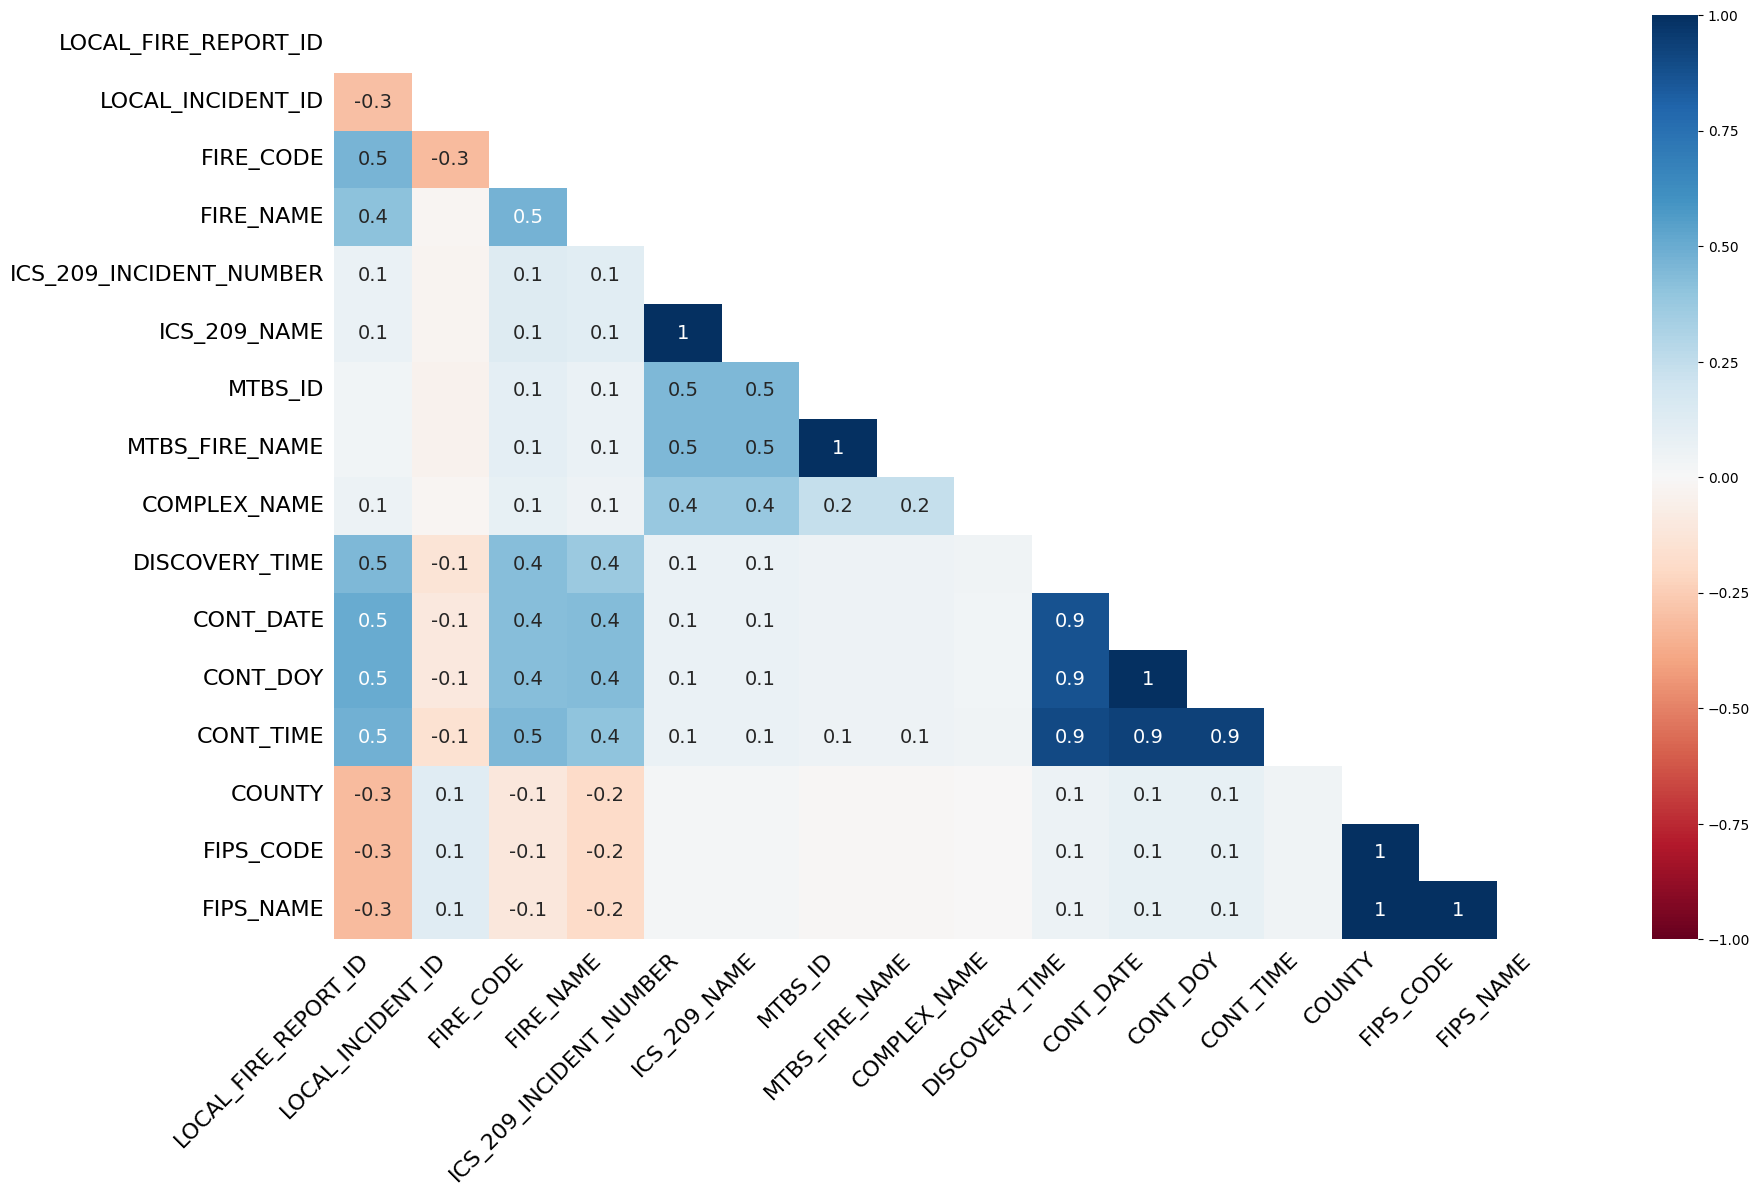

In [7]:
msno.heatmap(df)

Let look at if "is null" would leak any information.

Now let's look at some descriptions of numerical values

In [9]:
df.describe()

,OBJECTID,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,FIPS_CODE
count,5.714250e+05,5.714250e+05,571425.000000,5.714250e+05,571425.000000,314476.000000,3.059020e+05,305902.000000,286814.000000,571425.000000,571425.000000,571425.000000,571425.000000,359205.000000
mean,9.266425e+05,5.152594e+07,2003.697939,2.453061e+06,166.302769,1452.604940,2.453324e+06,174.615566,1540.321658,72.818371,37.101224,-95.785956,10.364897,99.875389
std,5.423844e+05,9.880682e+07,6.629826,2.422181e+03,89.574131,405.494339,2.630582e+03,83.517623,432.277391,2261.190807,5.784236,15.928370,4.479953,101.849369
min,1.000000e+00,1.000000e+00,1992.000000,2.448622e+06,1.000000,0.000000,2.448622e+06,1.000000,0.000000,0.000010,17.939722,-178.802600,0.000000,1.000000
25%,4.370660e+05,4.711850e+05,1998.000000,2.451140e+06,92.000000,1239.000000,2.451036e+06,105.000000,1320.000000,0.100000,32.868195,-110.133100,8.000000,29.000000
50%,9.492000e+05,1.076819e+06,2004.000000,2.453104e+06,167.000000,1458.000000,2.453550e+06,183.000000,1600.000000,1.000000,35.605000,-92.254700,14.000000,69.000000
75%,1.388606e+06,1.908442e+07,2009.000000,2.455036e+06,231.000000,1708.000000,2.455764e+06,233.000000,1814.000000,3.000000,41.033200,-82.566000,14.000000,125.000000
max,1.880465e+06,3.003484e+08,2015.000000,2.457388e+06,366.000000,2359.000000,2.457388e+06,366.000000,2359.000000,537627.000000,70.138100,-65.275556,15.000000,810.000000


We can see that the FIRE_SIZE have low values in the first 75% data, but the max is 537k, so that might cuase a problem later.

We can see that the data is very imbalanced, so it will cuase potential problem later.

Now let's look at the correlation between numerical columns

<Axes: >

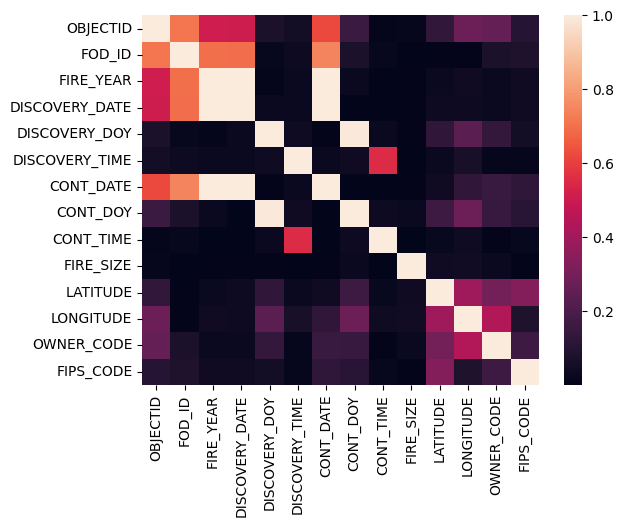

In [10]:
numerical_columns = ['OBJECTID','FOD_ID', 'FIRE_YEAR','DISCOVERY_DATE',
               'DISCOVERY_DOY',	'DISCOVERY_TIME',	'CONT_DATE',	'CONT_DOY',
               'CONT_TIME',	'FIRE_SIZE',	'LATITUDE',	'LONGITUDE','OWNER_CODE','FIPS_CODE']
df_for_correlation = df[numerical_columns]
sns.heatmap(df_for_correlation.corr().abs())

Beside from the obviously related columns, there are a few things that stands out:  


1.   Latitude and longitude seems to be related to owner code
2.   OBJECT_ID, FOD_ID seems to be related to the dates.



There are more things that I have in mide, but we will not do it in the first attempt.  
I wonder how FIRE_SIZE_CLASS would correlate to other things? Since they are ordinal, thus can be encoded numerically.   


# Cleaning data


As the naive approach, we will simply drop all the columns that have any null values.

In [11]:
columns_with_null = df.columns[df.isnull().any()]

Let's see if there is any columns that contains wired values: letters in numerical column? No.

Let's see if there is leakage. Let's encode the target column, and see if there are correlations between target and columns that clearly have nothing to do with the target.  

In [12]:
# Generate one-hot encoding for the selected column
column_name = 'STAT_CAUSE_DESCR'
encoded_target = pd.get_dummies(df[column_name], prefix=column_name)

# for the naive approach, we will just look at all the numerical columns vs. the encoded target.
numerical_columns = ['OBJECTID','FOD_ID', 'FIRE_YEAR','OWNER_CODE','FIPS_CODE']
df_for_correlation = df[numerical_columns]

# Concatenate the one-hot encoded features with the original dataframe
df_for_correlation = pd.concat([df_for_correlation, encoded_target], axis=1)

<Axes: >

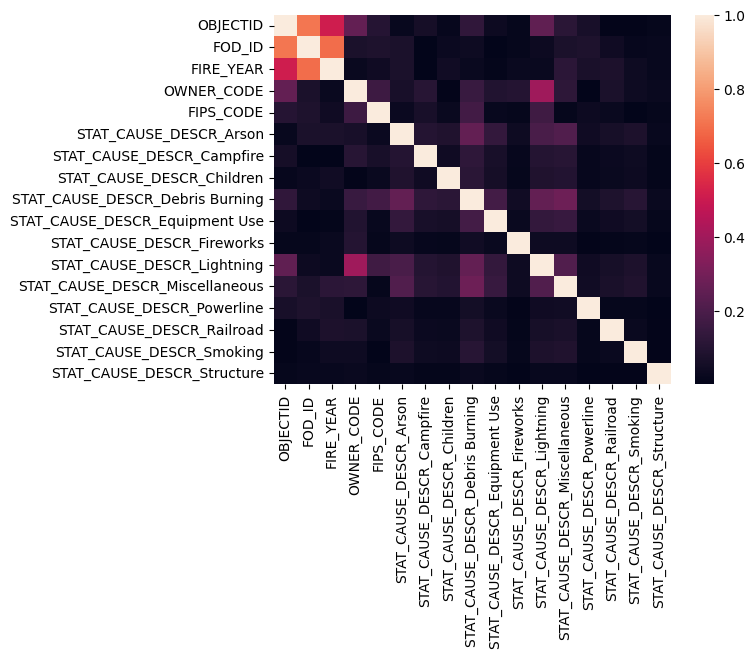

In [13]:
sns.heatmap(df_for_correlation.corr().abs())

We can see that one thing that's a bit concerning, is that there seems to be a slight correlation between the Lightning and OWNER_CODE.   
Also, why is there correlation between dummy values? shouldn't they be either 1 or 0? I will leave this question for now.

Another thing we need to check when checking for leakage, is should there be any columns that contains information we shouldn't know at the time of prediction?  
COMPLEX_ID seems to be a leakage? Because if it is not null, we have a fire in a complex......  
FIRE_NAME, FIRE_CODE probably also be eliminated. Because one shouldn't know FIRE_NAME before predicting the fire cuase.  
But following the same logic, NWCG_REPORTING_UNIT_NAME is a leakage too, because if it's a report from "forest service", then we know it's not a fire in city...
For simplicity, for the first attempt, we will delete FIRE_NAME, FIRE_CODE, COMPLEX_ID. (They contains null value, so we will not use them in the naive approach anyways. )

# Feature Engineering

## Catagprical Data
There are several catagorical data. For ordinal ones, we

# Training